In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
import math

In [2]:
# np.set_printoptions(2)

In [3]:
def lagrange_polys(
    points,
    nodes,
):
    n = len(nodes)
    
    xk = np.repeat(nodes.reshape(-1, 1), n-1, 1)
    xj = np.repeat(nodes.reshape(1, -1), n, 0)[~np.eye(n, dtype=bool)].reshape(n, -1)
    ls = []
    for x in points:
        lx = np.prod(x - xj, 1) / np.prod(xk - xj, 1)
        ls.append(lx)
    ls = np.array(ls)
    ls = ls.T
    return ls


def lagrange_inter(
    points,
    nodes,
    values,
):
    assert len(nodes.shape) == len(values.shape) == 1
    assert len(nodes) == len(values)

    output = np.zeros_like(points)

    polys = lagrange_polys(points, nodes)
    polys = polys.T

    for i, poly in enumerate(polys):
        output[i] = np.sum(poly * values)
    return output

# Probleme

## 1

In [4]:
def same(*args):
    for arg in args:
        assert args[0] == arg
    return args[0]

In [20]:
class Polynomial:
    def __init__(self, coeff):
        if isinstance(coeff, list):
            coeff = np.array(coeff)
        
        same(1, len(coeff.shape))
        i = len(coeff)-1
        while i >= 0 and coeff[i] == 0:
            i -= 1
        coeff = coeff[:i+1]
        self.coeff = coeff

    def diff(self):
        coeff = self.coeff[1:]
        coeff *= np.arange(0, len(coeff))+1
        return Polynomial(coeff)

    def len(self):
        return len(self.coeff)
    
    def __add__(self, other):
        len_ = max(self.len(), other.len())
        coeff = np.zeros(len_)
        coeff[:self.len()] += self.coeff
        coeff[:other.len()] += other.coeff
        return Polynomial(coeff)
    
    def __mul__(self, other):
        len_ = self.len() + other.len() - 1
        coeff = np.zeros(len_)
        for i, sc in enumerate(self.coeff):
            for j, oc in enumerate(other.coeff):
                coeff[i+j] += sc*oc
        return Polynomial(coeff)
    
    def eval(self, x):
        x = np.reshape(x, (-1, 1))
        return np.sum(x**np.arange(self.len()) * self.coeff, 1)

In [21]:
def hermite_poly(
    nodes,
    values,
    values_d,
) -> Polynomial:
    same(1, len(nodes.shape), len(values.shape), len(values_d.shape))
    m = same(nodes.shape[0], values.shape[0], values_d.shape[0])
    
    z = np.repeat(nodes, 2)
    Q = np.zeros((2*m, 2*m))
    Q[:, 0] = np.repeat(values, 2)
    Q[np.arange(m)*2+1, 1] = values_d

    r = np.arange(1, m)
    Q[(r-1)*2+2, 1] = (Q[r*2, 0] - Q[r*2 - 1, 0]) / (z[r*2] - z[r*2 - 1])

    for i in range(2, 2*m):
        for j in range(2, i+1):
            Q[i, j] = (Q[i, j-1] - Q[i-1, j-1]) / (z[i] - z[i-j])

    d = np.diag(Q)
    poly_acc = Polynomial([1])
    poly = Polynomial([])
    for i in range(2*m):
        poly = poly + poly_acc * Polynomial([d[i]])
        poly_acc = poly_acc * Polynomial([-z[i], 1])
    return poly


nodes = np.array([1.3, 1.6, 1.9])
values = np.array([0.6200860, 0.4554022, 0.2818186])
values_d = np.array([-0.5220232, -0.5698959, -0.5811571])
p = hermite_poly(
    nodes,
    values,
    values_d,
)
p.eval(np.array([1.5]))

array([0.5118277])

## 2

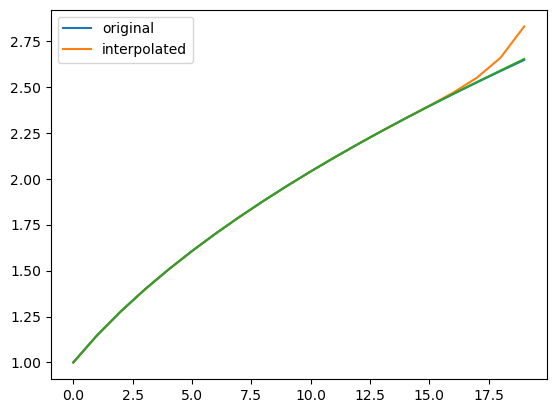

In [15]:
points = np.linspace(1, 7, 20)
nodes = np.linspace(1, 5, 5)
values = np.sqrt(nodes)
values_d = 1/2 * 1/np.sqrt(nodes)

plt.plot(np.sqrt(points))

p = hermite_poly(
    nodes,
    values,
    values_d,
)
p = p.eval(points)
plt.plot(p)

h = CubicHermiteSpline(nodes, values, values_d)
plt.plot(h(points))

plt.legend(["original", "interpolated"])

## 3

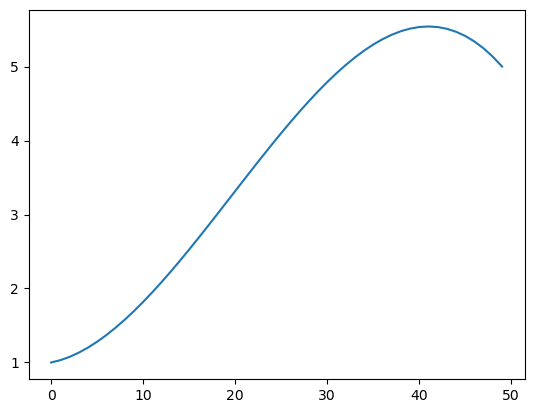

In [8]:
p0 = 1
m0 = 1.2
p1 = 5
m1 = -7

t = np.linspace(0, 1, 50)
p = (
    + (2*t**3 - 3*t**2 + 1)*p0
    + (t**3 - 2*t**2 + t)*m0
    + (-2*t**3 + 3*t**2)*p1
    + (t**3 - t**2)*m1
)
plt.plot(p)

# Probleme practice

## 1

In [64]:
point = 0.25

print("actual value", np.exp(point))

nodes = np.array([0, 1, 2])
values = np.exp(nodes)
values_d = np.exp(nodes)
p = hermite_poly(
    nodes,
    values,
    values_d,
)
print("my hermite", p.eval(np.array([point]))[0])

p = lagrange_inter(
    np.array([point]),
    nodes,
    values,
)[0]
print("my lagrange", p)

h = CubicHermiteSpline(nodes, values, values_d)
p = h(point)
print("hermite", p)

actual value 1.2840254166877414
my hermite 1.2836450992199069
my lagrange 1.1527742906760838
hermite 1.281687074987708


$n+1=6$

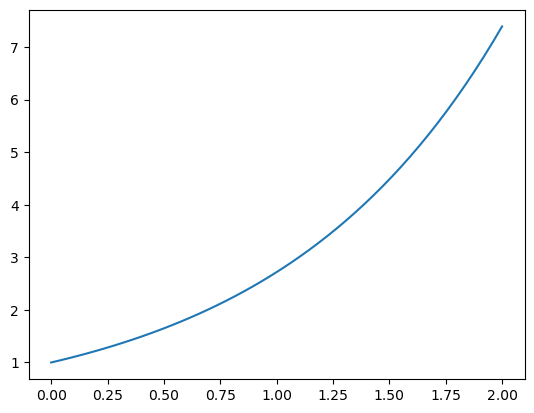

In [65]:
err_points = np.linspace(np.min(nodes), np.max(nodes))
plt.plot(err_points, np.exp(err_points))

=> valoarea maxima a lui $e^x,x\in(\min{\{x_k\mid k=\overline{0,m}\}},\max{\{x_k\mid k=\overline{0,m}\}})$ se obtine pentru ultimul nod, $x_2=2$

In [66]:
max_err = math.prod((point-node)**2 for node in nodes) / math.factorial(6) * math.e**nodes[2]
print("max error", max_err)

max error 0.0011049308741687069


## 2

In [53]:
point = 0.34
nodes = np.array([0.30, 0.32, 0.35])
values = np.array([0.29552, 0.31457, 0.34290])
values_d = np.array([0.95534, 0.94924, 0.93937])
p = hermite_poly(
    nodes,
    values,
    values_d,
)
p = p.eval([point])[0]

$n+1=6$

$\sin^{(6)}(x)=-\sin(x)$

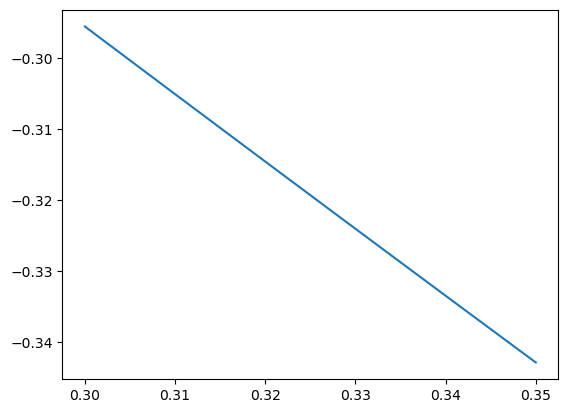

In [54]:
err_points = np.linspace(np.min(nodes), np.max(nodes))
plt.plot(err_points, -np.sin(err_points))

=> valoarea maxima a lui $-sin(x),x\in(\min{\{x_k\mid k=\overline{0,m}\}},\max{\{x_k\mid k=\overline{0,m}\}})$ se obtine pentru primul nod, $x_0=0.30$

In [55]:
print("error", np.abs(p - np.sin(point)))

max_err = math.prod((point-node)**2 for node in nodes) / math.factorial(6) * -math.sin(nodes[0])
print("max error", max_err)

error 1.7979332609385779e-06
max error -2.626846281434114e-14


In [60]:
point = 0.34
nodes = np.array([0.30, 0.32, 0.33, 0.35])
values = np.array([0.29552, 0.31457, 0.32404, 0.34290])
values_d = np.array([0.95534, 0.94924, 0.94604, 0.93937])
p = hermite_poly(
    nodes,
    values,
    values_d,
)
p = p.eval([point])[0]

$n+1=8$

$\sin^{(8)}(x)=\sin(x)$

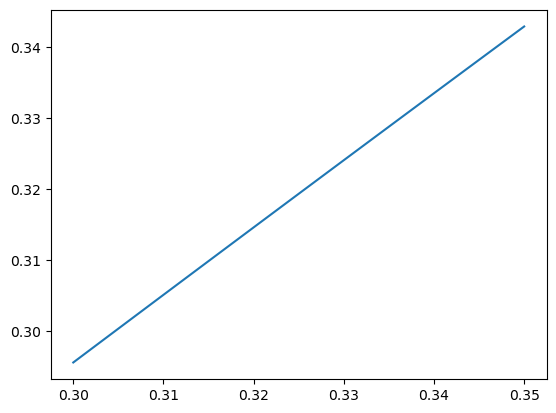

In [61]:
err_points = np.linspace(np.min(nodes), np.max(nodes))
plt.plot(err_points, np.sin(err_points))

=> valoarea maxima a lui $sin(x),x\in(\min{\{x_k\mid k=\overline{0,m}\}},\max{\{x_k\mid k=\overline{0,m}\}})$ se obtine pentru ultimul nod, $x_3=0.35$

In [62]:
print("error", np.abs(p - np.sin(point)))

max_err = math.prod((point-node)**2 for node in nodes) / math.factorial(len(nodes)*3) * math.sin(nodes[3])
print("max error", max_err)

error 1.0684450870268591e-05
max error 4.5815002866689385e-24


## 3

distanta 742.5028390987754
viteza 48.38173636397187


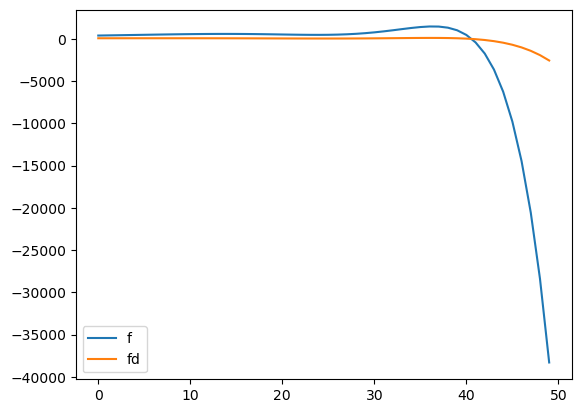

In [12]:
point = 10
nodes = np.array([0, 3, 5, 8, 13])
values = np.array([0, 225, 383, 623, 993])
values_d = np.array([75, 77, 80, 74, 72])
p = hermite_poly(
    nodes,
    values,
    values_d,
)
print("distanta", p.eval([point])[0])
pd = p.diff()
print("viteza", pd.eval([point])[0])

plt.plot(p.eval(np.linspace(5, 15)))
plt.plot(pd.eval(np.linspace(5, 15)))
plt.legend(["f", "fd"])